In [ ]:
import shutil
import os
if os.path.exists('/content/DL_Final_Project_RL'):
  os.chdir('/content/')
  shutil.rmtree('/content/DL_Final_Project_RL')
print(os.getcwd())

/content


In [ ]:
!git clone https://github.com/BenjaminPhan34/DL_Final_Project_RL

Cloning into 'DL_Final_Project_RL'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 30 (delta 12), reused 24 (delta 9), pack-reused 0
Receiving objects: 100% (30/30), 50.22 KiB | 12.55 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [ ]:
os.chdir('/content/DL_Final_Project_RL')

In [ ]:
!pip install PyBoy

  Using cached pyboy-1.6.9-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (29.3 MB)
  Using cached PySDL2-0.9.16.tar.gz (773 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 35.3 MB/s eta 0:00:00
  Created wheel for pysdl2: filename=PySDL2-0.9.16-py3-none-any.whl size=580348 sha256=6ff63eb707820ba8e5ef01141f525f58f27d5f2acdb20af2222aa775ccf35bfe
  Stored in directory: /root/.cache/pip/wheels/51/b5/7e/69bd9862192aa17f26f6f2138a046136a27df8c7e72f4fcc3b
Successfully built pysdl2


Download previous save

In [ ]:
#!gdown 1--ngmWrpN9mHC2bJyzY_5Ji8ers5_KdJ
#!gdown 1BRzSXnVi8UFc7y6QO4wmmL5EANtk5J1m
#!gdown 1ZnphHZzZIGV7gQwqaXGacDLfArnuYy4d
#!gdown 1GMJj6o7pJGmbnY1gwS1WfJBu72Itn79m

Downloading...
From: https://drive.google.com/uc?id=1--ngmWrpN9mHC2bJyzY_5Ji8ers5_KdJ
To: /content/DL_Final_Project_RL/lastTrain_agentVersion.keras
100% 6.48M/6.48M [00:00<00:00, 22.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1BRzSXnVi8UFc7y6QO4wmmL5EANtk5J1m
To: /content/DL_Final_Project_RL/lastTarget_agentVersion.keras
100% 6.48M/6.48M [00:00<00:00, 28.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ZnphHZzZIGV7gQwqaXGacDLfArnuYy4d
To: /content/DL_Final_Project_RL/saved_buffer.txt
100% 174M/174M [00:01<00:00, 92.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1GMJj6o7pJGmbnY1gwS1WfJBu72Itn79m
To: /content/DL_Final_Project_RL/MarioLand_history.txt
100% 1.59M/1.59M [00:00<00:00, 186MB/s]








Total Memory: 51.00 GB
Available Memory: 25.22 GB
Used Memory: 25.16 GB
Memory Usage Percentage: 50.6%
Numbers of episodes 843 | Exploration proba 0.43084796522795343 
Reward Action 3 | Total Reward Episode 50 | Frame n° 66
1/1 [==============================] - 0s 18ms/step


KeyboardInterrupt: ignored

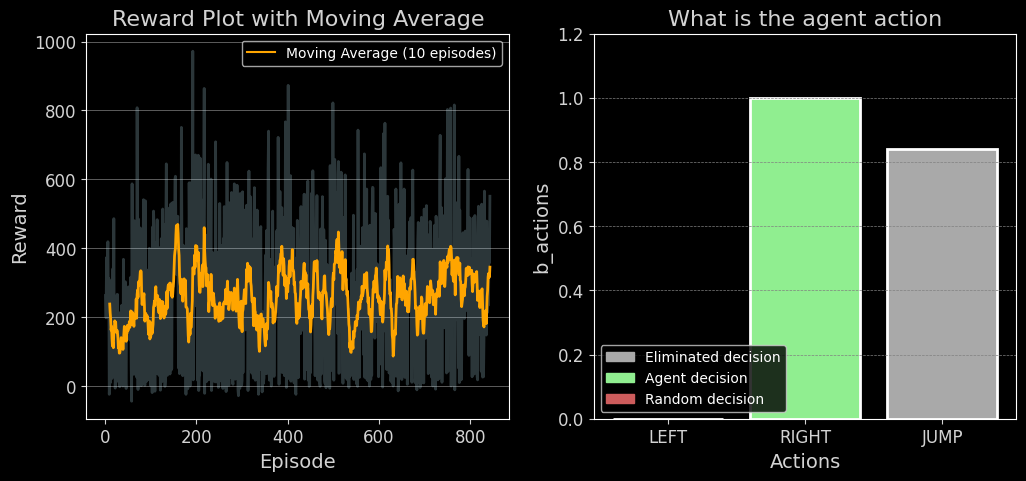

In [ ]:
# IMPORTS
from IPython.display import clear_output
from AgentManager import AgentManager
from MemoryManager import MemoryManager
from VisualizationBoard import *
from utilities import *
import time
import gc
from DQNAgent import *
from pyboy import PyBoy, WindowEvent
import sys


CONTINUE = 1
NEW = 0

def main():


    #Path to the game
    rom_path = "Super-Mario-Land-JUE-V1.1-.gb"

    #List of the possible action
    possible_actions = [WindowEvent.PRESS_ARROW_LEFT, WindowEvent.PRESS_ARROW_RIGHT, WindowEvent.PRESS_BUTTON_A]
    release = [WindowEvent.RELEASE_ARROW_LEFT, WindowEvent.RELEASE_ARROW_RIGHT, WindowEvent.RELEASE_BUTTON_A]

    # GAME LAUNCHING
    pyboy = PyBoy(rom_path, game_wrapper=True , disable_renderer=True)
    pyboy.set_emulation_speed(0) #cocaine mode  (ATTENTION: skip every pyboy tick)
    assert pyboy.cartridge_title() == "SUPER MARIOLAN"
    mario = pyboy.game_wrapper()
    mario.start_game(timer_div=None, world_level=None, unlock_level_select=False)

    assert mario.score == 0
    assert mario.lives_left == 2
    assert mario.time_left == 400
    assert mario.world == (1, 1)
    assert mario._level_progress_max == 0
    assert mario.fitness == 0 # A built-in fitness score for AI development

    ###### IMPORTANT CHOOSE THE MODE "NEW" TRAINING OR "CONTINUE" TRAINING ######
    MODE = NEW

    ###### Power off computer if True
    AUTOSHUTDOWN = False

    #Initialisation
    last_fitness = 0

    total_steps = 0
    reward_epi = 0
    fr = 0
    action_size = len(possible_actions)

    nbChan = 5
    #nbChan = 1


    agent_manager = AgentManager(action_size, nbChan, MODE)
    visualisation = VisualizationBoard("MarioLand_history.txt", disable_visualization = True)
    memory_manager = MemoryManager(threshold=95)
    total_episodes = visualisation.nb_episodes
    print("Begin at episode :",total_episodes)
    current_states = np.transpose(np.array(get_states(nbChan,15,mario,pyboy)), (1, 2, 0))
    last_mario = LastMario(mario)

    # Loop for the training session
    episodesMax = total_episodes + 700
    frame = 0
    while total_episodes < episodesMax:


        action = possible_actions[agent_manager.train_agent.compute_action(current_states)]
        visualisation.show_action_bar(agent_manager.train_agent.q_values)

        pyboy.send_input(action)

        next_states = np.transpose(np.array(get_states(nbChan,15,mario,pyboy)), (1, 2, 0))

        pyboy.send_input(release[possible_actions.index(action)])
        pyboy.tick()

        frame += 1
        #reward = reward1(mario,last_lives,last_score)
        reward = reward_function(mario,last_mario)

        reward_epi += reward
        reward_epi = round(reward_epi,2)
        clear_output(wait=True)
        print("\n\n\n\n\n")
        memory_manager.display_memory_info()
        print("Numbers of episodes",total_episodes,"| Exploration proba",agent_manager.train_agent.exploration_proba,
            "\nReward Action",reward,"| Total Reward Episode",reward_epi,"| Frame n°",frame)

        next_input = np.array(next_states)

        # We sotre each experience in the memory buffer
        agent_manager.train_agent.store_episode(current_states, possible_actions.index(action), reward, next_input)
        current_states = next_states
        last_mario.updateLastMario(mario)

        if mario.lives_left==0 or mario.time_left<200:
            print("End of the current episode")
            if agent_manager.train_agent.experience_memory.get_size() >= agent_manager.train_agent.train_size:
                total_steps = 0
                history = agent_manager.train_agent.train(agent_manager.target_agent)
                history["exploration_proba"] = agent_manager.train_agent.exploration_proba
                history["reward_episode"] = reward_epi
                total_episodes+=1


                with open("MarioLand_history.txt", 'a') as file:
                    json.dump(history, file)
                    file.write('\n')

                agent_manager.train_agent.update_exploration_probability()
                print("Updating agent exploration_proba to",agent_manager.train_agent.exploration_proba)
                #Updating plot
                visualisation.save_rewards_plots(save_path="reward_plot.png")
                visualisation.save_loss_and_accuracy_plots(save_path="loss_accuracy_plot.png")
                visualisation.last_loss_and_accuracy_plots(save_path="last_loss_accuracy_plot.png")







            last_fitness=0

            mario.reset_game()
            reward_epi = 0
            frame = 0
            current_states = np.transpose(np.array(get_states(nbChan,15,mario,pyboy)), (1, 2, 0))
            last_mario.updateLastMario(mario)
            assert mario.lives_left == 2

            if total_episodes%50 == 0:
                agent_manager.target_agent.model.set_weights(agent_manager.train_agent.model.get_weights())
                agent_manager.target_agent.model.save('lastTarget_agentVersion.keras')

            agent_manager.train_agent.model.save('lastTrain_agentVersion.keras')
            save_buffer("saved_buffer.txt",agent_manager.train_agent)
            tf.keras.backend.clear_session()
            del agent_manager.train_agent.model
            del agent_manager.target_agent.model
            gc.collect(generation=2)
            print("CLEARING MEMORY")

            time.sleep(2)
            agent_manager.target_agent.model = keras.models.load_model('lastTarget_agentVersion.keras')
            agent_manager.train_agent.model = keras.models.load_model('lastTrain_agentVersion.keras')
    # Save the model
    pyboy.stop()

    if AUTOSHUTDOWN:
        os.system('shutdown.exe /s /t 0')


if __name__ == "__main__":
    main()


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Save the model in google drive

In [ ]:
#!cp /content/DL_Final_Project_RL/lastTarget_agentVersion.keras /content/gdrive/MyDrive/Cincinnati
#!cp /content/DL_Final_Project_RL/lastTrain_agentVersion.keras /content/gdrive/MyDrive/Cincinnati
#!cp /content/DL_Final_Project_RL/saved_buffer.txt /content/gdrive/MyDrive/Cincinnati
#!cp /content/DL_Final_Project_RL/MarioLand_history.txt /content/gdrive/MyDrive/Cincinnati
